In [1]:
import cv2 as computer_vision
import numpy as dig
from google.colab.patches import cv2_imshow

# PROBLEM 1

###extract_crossings()
####Function to extract the crossing point (intersection) between two lines.
####The lines are given as a list in the input.

In [2]:
def extract_crossings(lns):

    l_1, l_2 = lns
    x_a, y_a, x_b, y_b = l_1
    x_c, y_c, x_d, y_d = l_2

    x_distance = x_a - x_b
    x_distance2 = x_c - x_d
    y_distance = y_a - y_b
    y_distance2 = y_c - y_d

    # determinant
    determin = x_distance * y_distance2 - x_distance2 * y_distance

    # check for parallel lines [to mitigate float divide by zero error]
    if determin == 0:
        return None

    # Cramer rule = finding the crossings
    inverse_determin = 1.0 / determin
    xy_line1 = x_a*y_b - y_a*x_b
    xy_line2 = x_c*y_d - y_c*x_d
    x_cross = (xy_line1 * x_distance2 - x_distance * xy_line2)*inverse_determin
    y_cross = (xy_line1 * y_distance2 - y_distance * xy_line2)*inverse_determin

    # Check if crossing is part of line
    isXpartOfLine1 = min(x_a, x_b) <= x_cross <= max(x_a, x_b)
    isXpartOfLine2 = min(x_c, x_d) <= x_cross <= max(x_c, x_d)
    isYpartOfLine1 = min(y_a, y_b) <= y_cross <= max(y_a, y_b)
    isYpartOfLine2 = min(y_c, y_d) <= y_cross <= max(y_c, y_d)

    if (isXpartOfLine1 and isXpartOfLine2 and isYpartOfLine1 and isYpartOfLine2):
        # extract the point
        return (int(x_cross), int(y_cross))
    else:
        return None

###paper_detector()
#### Function to give output video with paper detected marked via boundaries for an input video

In [3]:
def paper_detector(input_video_path, output_video_path):

    # Get input video
    ip_video = input_video_path
    vid_obj = computer_vision.VideoCapture(ip_video)

    # Get video data
    img_width = int(vid_obj.get(computer_vision.CAP_PROP_FRAME_WIDTH))
    img_height = int(vid_obj.get(computer_vision.CAP_PROP_FRAME_HEIGHT))
    frame_rate = vid_obj.get(computer_vision.CAP_PROP_FPS)
    frames_total = int(vid_obj.get(computer_vision.CAP_PROP_FRAME_COUNT))

    # Output video object
    op_video = computer_vision.VideoWriter(output_video_path, computer_vision.VideoWriter_fourcc(*'mp4v'), frame_rate, (img_width, img_height))

    f_blur = 0
    isLooping = True

    while isLooping:

        # get one frame from input video
        isImg, frame = vid_obj.read()

        if not isImg:
            isLooping = False

        if isLooping == False:
            continue

        # Get grayscale img
        img_gry = computer_vision.cvtColor(frame, computer_vision.COLOR_BGR2GRAY)

        # calaculate laplacian variance
        laplace_kernel = dig.array([[0,1,0],[1,-4,1],[0,1,0]])
        laplace_score = computer_vision.filter2D(img_gry, -1, laplace_kernel).var()

        threshold_blur = 59
        # Check blur
        if laplace_score < threshold_blur:
            # if blur, just record blur frame count
            f_blur += 1
        else:
            # convert to binary image
            thr, img_binary = computer_vision.threshold(
                img_gry, 205, 255, computer_vision.THRESH_BINARY)

            # detecting edges using canny
            detected_edg = computer_vision.Canny(img_binary, 51, 150, apertureSize=3)
            detected_lin = computer_vision.HoughLinesP(detected_edg, 1, dig.pi/180, threshold=51, minLineLength=51, maxLineGap=51)

            detected_lin_lst = []
            # Iterate over points
            line_count = 0
            for p in detected_lin:
                # Extracted points nested in the list
                x_a, y_a, x_b, y_b = p[0]
                line_length = dig.sqrt((x_b - x_a)*(x_b - x_a) + (y_b - y_a)*(y_b - y_a))

                if line_count ==4:
                  break

                if line_length >= 109 and line_length < 400:

                    if (x_b - x_a )!= 0:
                        angle = dig.arctan2(y_b - y_a, x_b - x_a) * 180 / dig.pi

                        px = img_binary[y_a][x_a]
                        px2 = img_binary[y_b][x_b]

                        isAngleRange1 = 48<=angle<=89
                        isAngleRange2 = -28<=angle<=-1
                        isAngleRange3 =  1<=angle <=12

                        if isAngleRange1 or isAngleRange2 or isAngleRange3:

                            computer_vision.line(frame, (x_a, y_a), (x_b, y_b), (255, 100, 100), 3)
                            detected_lin_lst.append([x_a, y_a, x_b, y_b])
                            line_count +=1

            # lengthen the lines so that there is guarantee of intersection
            e_l = []
            for l in detected_lin_lst:
                x_a, y_a, x_b, y_b = l
                x_d = x_b - x_a
                y_d = y_b - y_a
                px_length = 300
                sqr = dig.sqrt(x_d*x_d + y_d*y_d)
                x_a_e = x_a - px_length * x_d / sqr
                y_a_e = y_a - px_length * y_d / sqr
                x_b_e = x_b + px_length * x_d / sqr
                y_b_e = y_b + px_length * y_d / sqr
                e_l.append([int(x_a_e), int(y_a_e), int(x_b_e), int(y_b_e)])

            # Get crossings between lines (intersections)
            crossings = []
            for itr in range(len(e_l)):
                for itr_2 in range(1+itr, len(e_l)):
                    intersection_pnt = extract_crossings([e_l[itr], e_l[itr_2]])
                    if intersection_pnt:
                        crossings.append(intersection_pnt)

            # Verify using Harris
            if crossings:
                detected_crnrs = computer_vision.cornerHarris(
                    dig.float32(img_gry), 2, 3, 0.04)
                detected_crnrs = computer_vision.dilate(detected_crnrs, None)
                for intersection_pnt in crossings:
                    x, y = intersection_pnt
                    if 0 <= x < frame.shape[1] and 0 <= y < frame.shape[0]:
                        if detected_crnrs[y, x] > 0.0099 * detected_crnrs.max():
                            computer_vision.circle(
                                frame, (x, y), 7, (100, 100, 255), -1)
            # Save frame in output video object
            op_video.write(frame)


    op_video.release()
    vid_obj.release()


    print("Total frames in input video:", frames_total)
    print("Number of blurry frames removed:", f_blur)
    print("Total frames in output video:", frames_total - f_blur)

### Executing the pipeline...

In [4]:
paper_detector('/content/proj2_v2.mp4','/content/output_video.mp4' )

Total frames in input video: 386
Number of blurry frames removed: 213
Total frames in output video: 173


# PROBLEM 2
##A

Here, **SIFT** is used for feature extraction beacuse it has many advantages.

First advantage is that it is invariant to scale and rotation between the images.

Another advantage being robust to changes in illumination. In the input images we can see that there is difference in illumination. Hence, SIFT can be used well here.

###mosaicking()
####Takes list of image paths as input
####Output - stitched image as well as feature matched images

In [5]:

def mosaicking(image_path_list):

    original_images = []

    # Get images object
    for single_image in image_path_list:
        # Read image
        original_images.append(computer_vision.imread(single_image))

    gry_scald_images = []
    keypnts_list = []
    feature_dscrptrs = []

    s_i_f_t_algo = computer_vision.SIFT_create()

    features_mtchd_list = []
    imgs_mtchd = []

    for original_image in original_images:
        # Get gray images
        gryed_image = computer_vision.cvtColor(original_image, computer_vision.COLOR_BGR2GRAY)

        # Get keypoints and descriptors
        key_pnts, nt_rqd = s_i_f_t_algo.detectAndCompute(gryed_image, None)

        keypnts_list.append(key_pnts)
        gry_scald_images.append(gryed_image)


    # Iterate through image pairs
    number_of_images = len(original_images)
    for img_pos in range(number_of_images - 1):

        feature_mtchr = computer_vision.BFMatcher()

        # Get keypoints and descriptor for consequtive imgs

        key_pnts_a, dscrptr_a = s_i_f_t_algo.detectAndCompute(gry_scald_images[img_pos], None)
        key_pnts_b, dscrptr_b = s_i_f_t_algo.detectAndCompute(gry_scald_images[img_pos + 1], None)

        # keypoint matching
        features_mtchd = feature_mtchr.knnMatch(dscrptr_a, dscrptr_b, k=2)

        valid_mtchs = []

        for a_ftr, b_ftr in features_mtchd:
            if a_ftr.distance < 0.725 * b_ftr.distance:
                valid_mtchs.append(a_ftr)

        features_mtchd_list.append(valid_mtchs)
        feature_dscrptrs.append((dscrptr_a, dscrptr_b))

        # Draw matched keypoints among the images
        matched_img = computer_vision.drawMatches(original_images[img_pos], key_pnts_a, original_images[img_pos + 1], key_pnts_b, valid_mtchs, None, flags=computer_vision.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        imgs_mtchd.append(matched_img)

    # Start mosaic image with first image in list
    mosaic_img = original_images[0]

    # Move along pairs of images
    for img_pos, valid_mtchs in enumerate(features_mtchd_list):
        valid_mtchs = features_mtchd_list[img_pos]
        index_img_a = img_pos
        index_img_b = 1+ img_pos

        # Get keypoints in both images that match
        key_pnts_first = dig.float32([keypnts_list[index_img_a][m.queryIdx].pt for m in valid_mtchs]).reshape(-1, 1, 2)
        key_pnts_second = dig.float32([keypnts_list[index_img_a + 1][m.trainIdx].pt for m in valid_mtchs]).reshape(-1, 1, 2)

        # Get homography
        homo_grphy= get_Homo_grphy(key_pnts_first, key_pnts_second)
        img_w = mosaic_img.shape[1] + original_images[index_img_b].shape[1]
        img_h = max(mosaic_img.shape[0], original_images[index_img_b].shape[0])

        # perform warping
        mosaic_img = computer_vision.warpPerspective(mosaic_img, homo_grphy, (img_w, img_h))

        # join images
        mosaic_img[0:original_images[index_img_b].shape[0], 0:original_images[index_img_b].shape[1]] = original_images[index_img_b]

    return imgs_mtchd, mosaic_img


###get_Homo_graphy()
####Takes input two sets of keypoints and gives output the homography between them

In [6]:

def get_Homo_grphy(key_pnts_first, key_pnts_second):

    final_homo_grphy = None
    final_key_pnts = []

    count = 0

    while True:

        if (count >=950):
            break

        count +=1

        # select 4 keypoints randomly
        # select their matches
        ptr = dig.random.choice(len(key_pnts_first), 4, replace=False)
        key_pnts_first_smp = key_pnts_first[ptr]
        key_pnts_second_smp = key_pnts_second[ptr]

        if len(key_pnts_first_smp.shape) <= 2 or len(key_pnts_second_smp.shape) <= 2:
            continue

        # Get Homography A mtx
        matrix_a = []
        for pnt_first, pnt_second in zip(key_pnts_first_smp, key_pnts_second_smp):
            x_a, y_a = pnt_first[0][0], pnt_first[0][1]
            x_b, y_b = pnt_second[0][0], pnt_second[0][1]
            mat1 = [-x_a, -y_a, -1, 0, 0, 0, x_a*x_b, y_a*x_b, x_b]
            mat2 = [0, 0, 0, -x_a, -y_a, -1, x_a*y_b, y_a*y_b, y_b]
            matrix_a.append(mat1)
            matrix_a.append(mat2)

        matrix_a = dig.asarray(matrix_a)

        # Compute SVD
        _, __, vec_tr = dig.linalg.svd(matrix_a)

        # Homography mtx - last row
        matrix_homo_grphy = vec_tr[-1].reshape(3, 3)

        # Matrix normalization
        dnmntr = matrix_homo_grphy[2, 2]
        matrix_homo_grphy = matrix_homo_grphy / dnmntr

        # get projected keypoints
        key_pnts_ip = key_pnts_first.reshape(-1, 1, 2)
        key_pnts_second_proj = computer_vision.perspectiveTransform(key_pnts_ip, matrix_homo_grphy)
        # error in keypoints original vs projected
        key_pnt_err = dig.sqrt(dig.sum((key_pnts_second_proj - key_pnts_second) *(key_pnts_second_proj - key_pnts_second), axis=2))

        # inliers count
        distance_thrshld = 5
        key_pnts_inlir = dig.sum(key_pnt_err < distance_thrshld)

        # if more inliers, reset homography
        if key_pnts_inlir > len(final_key_pnts):
            final_homo_grphy = matrix_homo_grphy
            final_key_pnts = dig.where(key_pnt_err < distance_thrshld)[0]


    return final_homo_grphy


###Executing the pipeline...

Feature matched images...



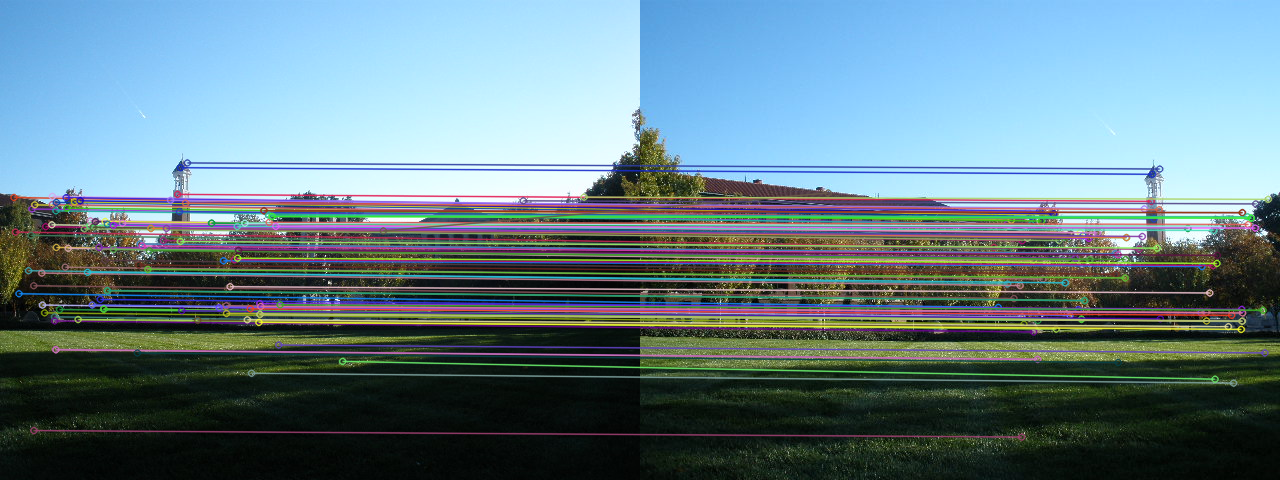

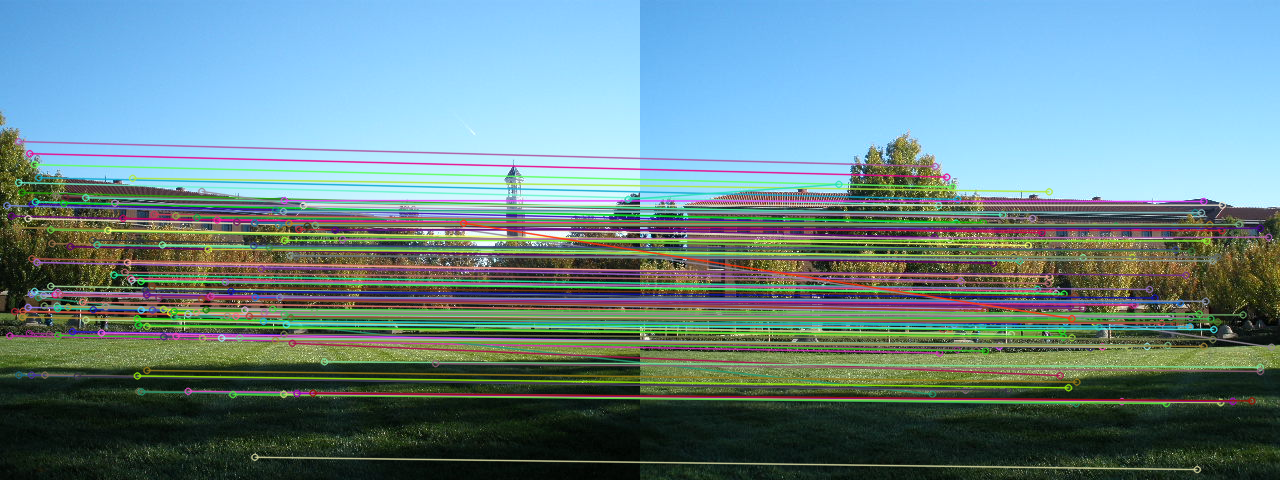

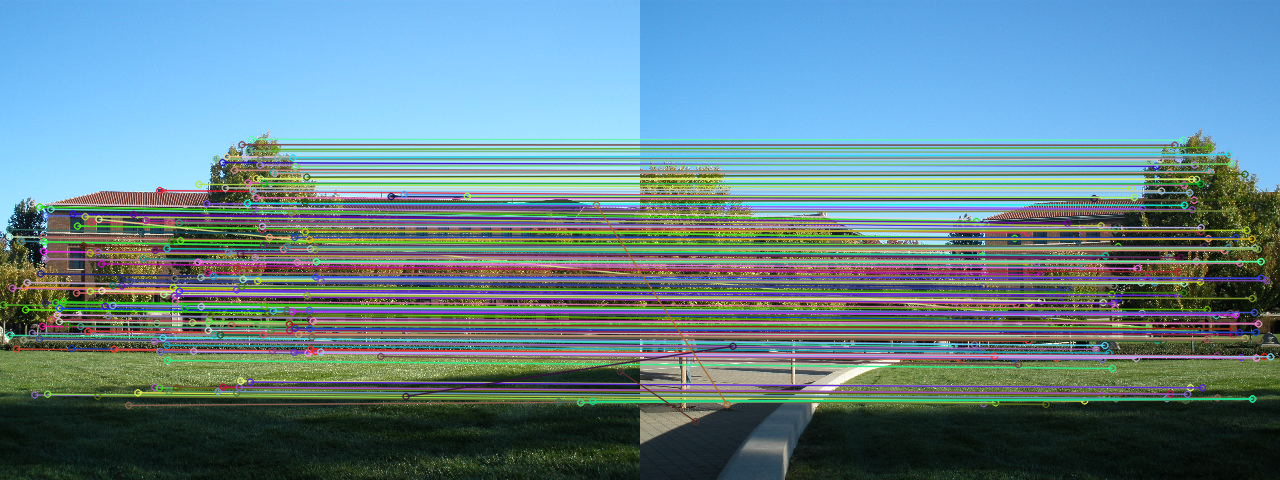


Stitched Image...



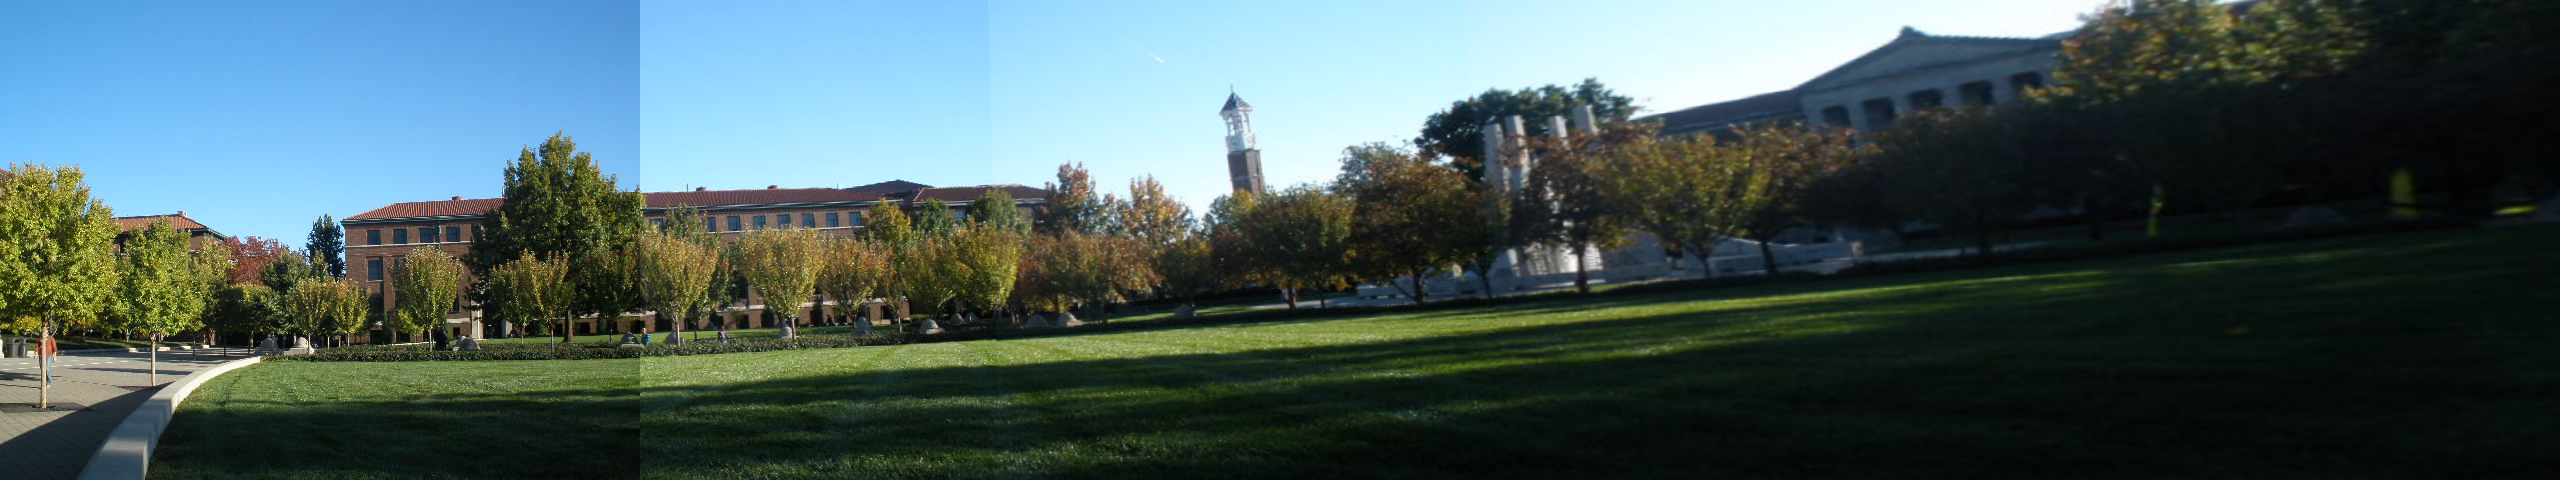

In [22]:

img_paths = ['/content/PA120272.JPG', '/content/PA120273.JPG', '/content/PA120274.JPG', '/content/PA120275.JPG']


# mosaicking
matched_imgs , final_img = mosaicking(img_paths)

count = 0
print ("Feature matched images...")
print ()
for img in matched_imgs:
  computer_vision.imwrite("/content/feature_img_"+ str(count)+".jpg", img)
  count+=1
  cv2_imshow(img)
  print ()

print ("Stitched Image...")
print()
cv2_imshow(final_img)


## B

####Panoramic mosaicing works better when the camera is only allowed to rotate at its camera center because there is little to no difference in Rotation and Scale of objects among the different images. Hence, there is only tanslational shift. This makes it easy to match the features between the different images and we get accurate stitched image. Additionally, parallax errors are also reduced to a minimum, which results in accurate stitching.